In [5]:
!pip install torch
!pip install matplotlib
!pip install numpy
!pip install kagglehub

  Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_universal2.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached numpy-2.3.0-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_universal2.whl (2.7 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached numpy-2

In [118]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import torch
import os
%matplotlib inline

In [119]:
def download_dataset() -> str:
    path = kagglehub.dataset_download("rishitjakharia/names-txt")
    return path # for easier access later

In [120]:
dataset_path = download_dataset() + "/names.txt"

In [121]:
words = open(dataset_path, 'r').read().splitlines()

In [122]:
def make_int_char_maps() -> tuple[dict, dict]:
  chars = sorted(list(set(''.join(words))))
  ctoi = {c: i + 1 for i, c in enumerate(chars)}
  ctoi['.'] = 0
  itoc = {i: c for c, i in ctoi.items()}
  return ctoi, itoc

In [123]:
ctoi, itoc = make_int_char_maps()

In [124]:
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [125]:
print(ctoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [126]:
vocab_size = len(ctoi)
print(vocab_size)

27


In [204]:
block_size = 7
def build_dataset(inp_words) -> tuple[torch.tensor, torch.tensor]:
  X, Y = [], []
  for w in words:
      # pad with '.' for start, append '.' for end
      padded = '.' * block_size + w + '.'
      for i in range(len(w) + 1):  # +1 to include the end token
          context = padded[i:i+block_size]
          target = padded[i+block_size]
          X.append([ctoi[c] for c in context])
          Y.append(ctoi[target])
  X = torch.tensor(X, dtype=torch.long)
  Y = torch.tensor(Y, dtype=torch.long)
  return X, Y

In [205]:
import random
random.seed(42)

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [208]:
Xtr.shape, Ytr.shape

(torch.Size([228146, 7]), torch.Size([228146]))

In [207]:
for x,y in zip(Xtr[:30], Ytr[:30]):
  print(''.join(itoc[ix.item()] for ix in x), '-->', itoc[y.item()])

....... --> n
......n --> a
.....na --> s
....nas --> i
...nasi --> a
..nasia --> h
.nasiah --> .
....... --> g
......g --> i
.....gi --> l
....gil --> a
...gila --> n
..gilan --> a
.gilana --> .
....... --> e
......e --> v
.....ev --> e
....eve --> r
...ever --> l
..everl --> e
.everle --> a
everlea --> .
....... --> k
......k --> h
.....kh --> y
....khy --> r
...khyr --> i
..khyri --> e
.khyrie --> .
....... --> s


In [191]:
import torch.nn as nn

In [224]:
n_emb = 32 # dimensionality of the character vectors
n_hidden = 150 # num hidden layer neurons

In [229]:
class RNN_Model(nn.Module):
    def __init__(self, vocab_size, n_emb, n_hidden):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.gru = nn.GRU(n_emb, n_hidden, num_layers=1, batch_first=True)
        self.linear = nn.Linear(n_hidden, vocab_size)

    def forward(self, x):
        # x: (batch, seq)
        x = self.embedding(x)                  # (batch, seq, n_emb)
        output, h_n = self.gru(x)              # output: (batch, seq, n_hidden)
        x = self.linear(output)                # (batch, seq, vocab_size)
        return x


In [230]:
model = RNN_Model(vocab_size, n_emb, n_hidden)

# make the last layer less confident
with torch.no_grad():
    model.linear.weight.mul(0.1)

params = model.parameters()
print(f"Num Params: {sum(p.nelement() for p in params)}")
for param in params:
    param.requires_grad = True


optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50_000, gamma=0.5) 


Num Params: 87741


In [231]:
print(model)

RNN_Model(
  (embedding): Embedding(27, 32)
  (gru): GRU(32, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=27, bias=True)
)


In [232]:
lossi = []
num_epochs = 100_000
batch_size = 64
model.train()

RNN_Model(
  (embedding): Embedding(27, 32)
  (gru): GRU(32, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=27, bias=True)
)

In [233]:
for i in range(num_epochs):

    ixs = torch.randint(Xtr.shape[0], (batch_size,))
    Yb = Ytr[ixs]
    Xb = Xtr[ixs]

    logits = model.forward(Xb)
    probs = logits.view(batch_size, -1)

    loss = F.cross_entropy(probs, Yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    extr_loss = loss.item()
    lossi.append(extr_loss)


    if (i+1) % 10_000 == 0:
        print(f"{i+1}/{num_epochs}, -> {extr_loss}")


    

10000/100000, -> 2.800567388534546
20000/100000, -> 2.787832498550415
30000/100000, -> 2.6847105026245117
40000/100000, -> 2.6579535007476807
50000/100000, -> 2.7418408393859863
60000/100000, -> 2.696767807006836
70000/100000, -> 2.6535120010375977
80000/100000, -> 2.9976890087127686
90000/100000, -> 3.0047433376312256
100000/100000, -> 2.8140430450439453


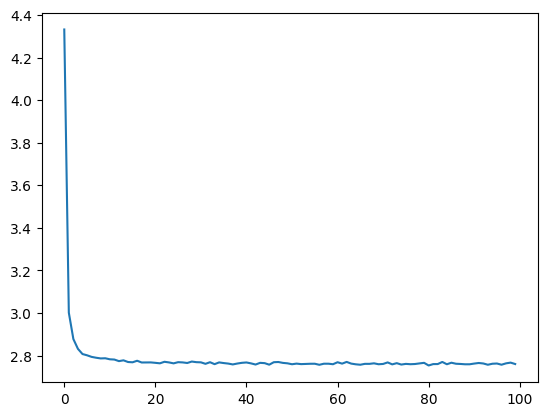

In [236]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [237]:
model.eval()


RNN_Model(
  (embedding): Embedding(27, 32)
  (gru): GRU(32, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=27, bias=True)
)

In [240]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    x = model(x)
    probs = x.view(x.shape[0], -1)
    loss = F.cross_entropy(probs, y)
    print(split, loss.item())

In [248]:
split_loss('train')
split_loss('val')

train 2.7619075775146484
val 2.7619075775146484


In [ ]:
with open("generated_names.txt", 'a') as f:
    names = []
    for _ in range(500):

        context = [0] * block_size  # or whatever index corresponds to '.'
        out = []
        while True:
            x = torch.tensor([context])
            logits = model(x)
            logits = logits[:, -1, :]  # Take the last timestep
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:  # assuming '.' index is 0
                break

    names.sort()
    f.write('\n'.join(names))


IndexError: index out of range in self

In [254]:
with open("generated_names.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        name = name.split('\n')[0]
        if name in words:
            print(f"{name} exists")
        
